# Chapter 1: Simple Visual Odometry - A Practical Demo

This notebook is the hands-on companion to the [Chapter 1 article](index.md). Here, we'll walk through a complete, runnable implementation of a **monocular visual odometry** system.

**Our goal**: To take a sequence of images from a car's dashboard camera and reconstruct the path it took, using only the visual information from the images.

We will follow these key steps:
1.  **Setup and Data Loading**: Automatically download the KITTI dataset.
2.  **Feature Detection & Matching**: Find and track distinctive points between images.
3.  **Pose Estimation**: Calculate the camera's motion from the matched points.
4.  **Trajectory Reconstruction**: Chain the movements together to build the full path.
5.  **Evaluation**: Compare our estimated path to the ground truth to see how well we did.

Let's get started!

In [1]:
# --- Imports and Setup ---
import sys
import os
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from tqdm import tqdm
import cv2

# Add the project root directory to the Python path
# This allows us to import our custom modules from the `src` directory
# Assumes the notebook is in `chapters/1/`
project_root = Path().resolve().parent.parent
sys.path.append(str(project_root))
print(f"Project root added to path: {project_root}")

# --- Our Project Modules ---
from src.datasets import KITTIDatasetFetcher
from src.feature_matching import FeatureMatcher
from src.pose_estimation import PoseEstimator
from src.visual_odometry import SimpleVisualOdometry, run_vo_pipeline
from src.utils import load_image, plot_trajectory, compute_trajectory_error, plot_top_down_trajectory

# --- Matplotlib Setup ---
# Set a professional and readable style for our plots
plt.style.use('seaborn-v0_8-pastel')
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['image.cmap'] = 'gray'
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

print("✅ Setup complete. All modules imported successfully.")

Project root added to path: /Users/ryan.porter/Projects/Navigation-for-the-GPS-Poor
✅ Setup complete. All modules imported successfully.


/opt/anaconda3/envs/py311/lib/python3.11/site-packages/requests/__init__.py:86: RequestsDependencyWarning: Unable to find acceptable character detection dependency (chardet or charset_normalizer).
  warnings.warn(


## Step 1: Download and Load the Dataset

Before we can do anything, we need data. We'll use the **KITTI Visual Odometry dataset**, which is a popular benchmark for this kind of task. It consists of video sequences recorded from a car driving around Karlsruhe, Germany.

Our `KITTIDatasetFetcher` utility will handle everything for us:
-   It will check if the data exists in the `data/` directory.
-   If not, it will download and extract the required files automatically.
-   It provides convenient methods for loading the images, calibration data, and ground truth poses.

We will use **Sequence 00**, a varied sequence that is great for testing.

In [1]:
# --- Configuration ---
SEQUENCE_ID = "00"
DATA_DIR = project_root / "data"

# --- Download ---
print("Setting up dataset...")
# This will automatically download and unzip the data if it's not already present
kitti_fetcher = KITTIDatasetFetcher(data_dir=DATA_DIR)
kitti_fetcher.download_sequence(SEQUENCE_ID)
print(f"✅ Sequence '{SEQUENCE_ID}' is ready.")

# --- Load ---
print("\nLoading dataset components...")
# Load camera calibration parameters
# We need the intrinsic matrix 'K' for our geometric calculations
calibration = kitti_fetcher.load_calibration(SEQUENCE_ID)
K = calibration['P0'][:, :3]

# Load the ground truth poses
# These are the "correct" answers we'll use to evaluate our results
ground_truth_poses = kitti_fetcher.load_poses(SEQUENCE_ID)

# Get the list of image file paths for the left camera
image_paths = kitti_fetcher.get_image_paths(SEQUENCE_ID, camera="image_0")

print(f"✅ Loaded {len(image_paths)} image paths.")
print(f"✅ Loaded {len(ground_truth_poses)} ground truth poses.")
print("✅ Loaded camera calibration matrix K:")
print(K)

Setting up dataset...
Dataset for sequence '00' already exists. Skipping download.
✅ Sequence '00' is ready.

Loading dataset components...
✅ Loaded 4541 image paths.
✅ Loaded 4541 ground truth poses.
✅ Loaded camera calibration matrix K:
[[718.856    0.     607.1928]
 [  0.     718.856  185.2157]
 [  0.       0.       1.    ]]


## Step 2: Feature Detection and Matching

The fundamental idea of visual odometry is to track how distinctive points in the environment move between consecutive camera frames.

1.  **Feature Detection**: We first scan an image to find visually interesting points—or "features"—that the computer can easily recognize again. These are typically corners, edges, or unique textures. We'll use the **ORB (Oriented FAST and Rotated BRIEF)** detector, which is fast, reliable, and well-suited for this task.
2.  **Feature Matching**: Once we have features for two consecutive images, we "match" them. For each feature in the first image, we find the feature in the second image that looks the most similar.

Let's see this in action on the first two frames of our sequence.

Found 607 good matches between the first two frames.


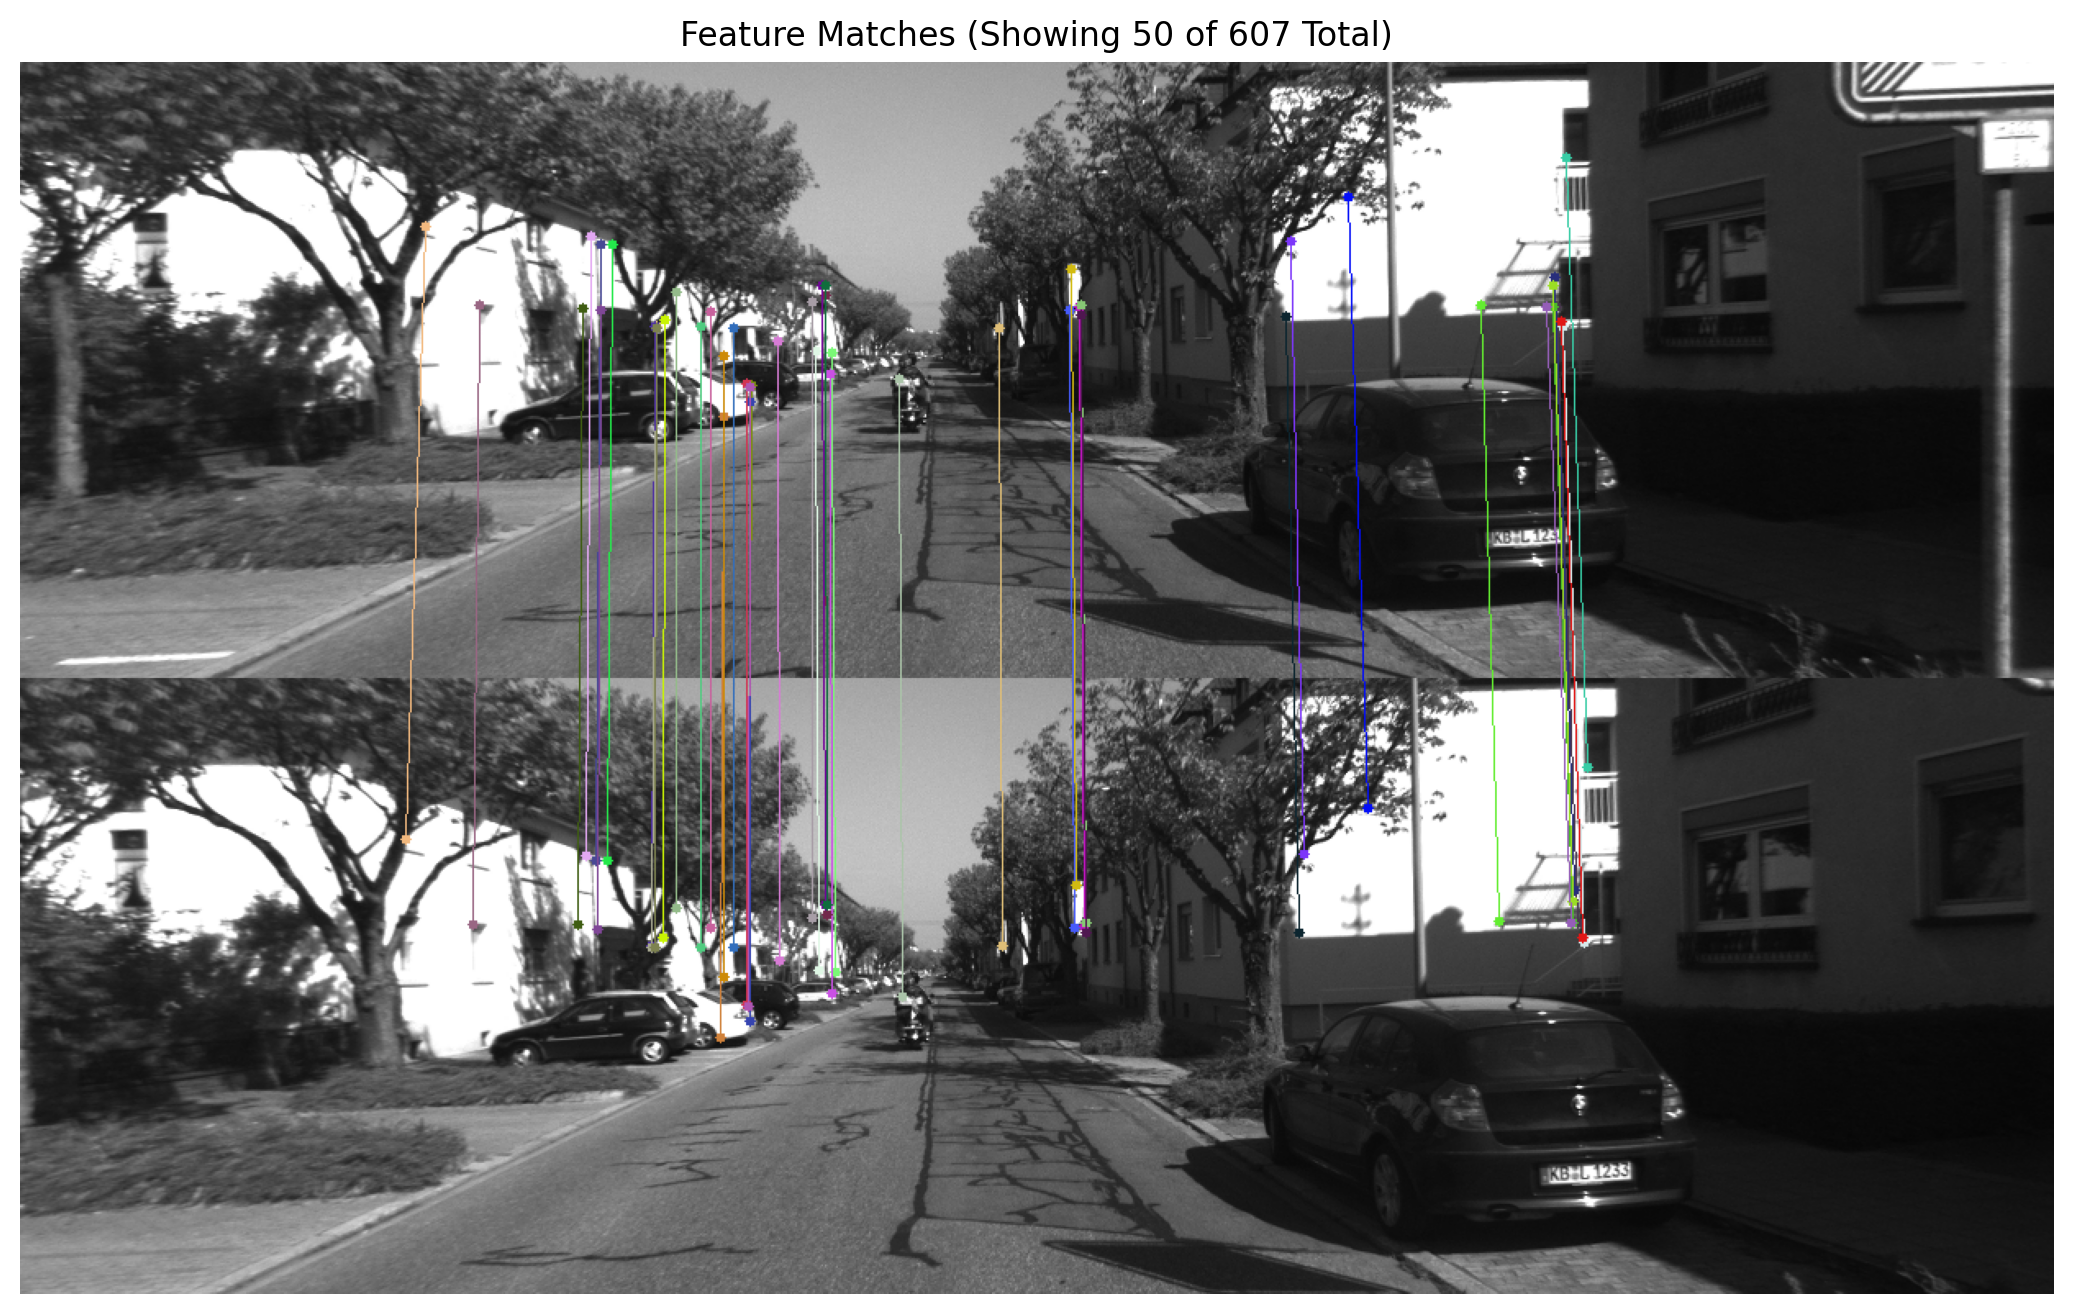

In [2]:
# --- Load First Two Images ---
img1_raw = load_image(image_paths[0], grayscale=True)
img2_raw = load_image(image_paths[1], grayscale=True)

# --- Initialize Feature Matcher ---
# We'll use ORB with a limit of 1000 features per image
feature_matcher = FeatureMatcher(detector_type='ORB', max_features=1000)

# --- Detect and Match ---
points1, points2 = feature_matcher.detect_and_match(img1_raw, img2_raw)
print(f"Found {len(points1)} good matches between the first two frames.")

# --- Visualize Matches ---
# The visualization shows the first 50 matches for clarity
matches_visualization = feature_matcher.visualize_matches(img1_raw, img2_raw, points1, points2, max_matches=50)

plt.figure(figsize=(16, 8))
plt.imshow(matches_visualization)
plt.title(f'Feature Matches (Showing 50 of {len(points1)} Total)')
plt.axis('off')
plt.show()

## Step 3: Estimate Camera Motion (Pose Estimation)

Once we know how the features moved, we can use geometry to solve for how the *camera* must have moved. The set of matched points contains all the information we need to recover the camera's **rotation (R)** and **translation (t)**.

The core of this process relies on the **Essential Matrix**, a mathematical construct that relates the matched points from two images, given the camera's intrinsic calibration (`K`).

Our `PoseEstimator` class handles this complex step:
1.  It takes the matched points and the camera matrix `K` as input.
2.  It uses an algorithm called **RANSAC (Random Sample Consensus)** to find the most likely camera motion, which robustly filters out any incorrect feature matches (outliers).
3.  It returns the rotation matrix `R` and the translation vector `t`.

**Important Note on Scale**: With a single camera, we can find the *direction* of translation, but not the *distance*. The returned translation vector `t` will have a correct direction but an arbitrary length (it's a unit vector). This is the famous **scale ambiguity** problem of monocular vision. For now, we'll see the direction is correct and later use ground truth to apply the correct scale.

In [3]:
# --- Initialize Pose Estimator ---
# The estimator needs the camera's intrinsic matrix K
pose_estimator = PoseEstimator(K)

# --- Estimate Pose ---
# We use the matched points from the previous step
R, t, inlier_mask = pose_estimator.estimate_pose_essential_matrix(points1, points2)

print("--- Estimated Motion ---")
print("Rotation (R):\n", R)
print("\nTranslation direction (t):\n", t.flatten())
print(f"\nFound {np.sum(inlier_mask)} inliers out of {len(points1)} matches.")

# --- Compare with Ground Truth ---
# To verify, let's get the ground truth motion between the first two frames
gt_motion = np.linalg.inv(ground_truth_poses[0]) @ ground_truth_poses[1]
gt_R = gt_motion[:3, :3]
gt_t = gt_motion[:3, 3]

print("\n--- Ground Truth Motion ---")
print("Rotation (R):\n", gt_R)
print("\nTranslation (t):\n", gt_t)

# --- Verify Translation Direction ---
# Our estimated `t` is a unit vector (direction only).
# The ground truth `gt_t` has the correct scale.
# Let's compare their directions.
t_unit = t.flatten() / np.linalg.norm(t)
gt_t_unit = gt_t / np.linalg.norm(gt_t)
direction_similarity = np.dot(t_unit, gt_t_unit)

print(f"\nSimilarity of translation direction: {direction_similarity:.4f}")
print("(A value close to 1.0 means the direction is correct)")

--- Estimated Motion ---
Rotation (R):
 [[ 0.99998935  0.00326495  0.00326333]
 [-0.00327299  0.99999162  0.00246048]
 [-0.00325527 -0.00247113  0.99999165]]

Translation direction (t):
 [ 0.00399941 -0.01809041 -0.99982836]

Found 283 inliers out of 607 matches.

--- Ground Truth Motion ---
Rotation (R):
 [[ 9.99997800e-01  5.27262791e-04 -2.06693502e-03]
 [-5.29650610e-04  9.99999200e-01 -1.15486524e-03]
 [ 2.06632418e-03  1.15595788e-03  9.99997200e-01]]

Translation (t):
 [-0.04690294 -0.02839928  0.85869419]

Similarity of translation direction: -0.9974
(A value close to 1.0 means the direction is correct)


## Step 4: Reconstructing the Full Trajectory

Now for the final step: we'll loop through the entire image sequence and chain these small, frame-to-frame movements together to build the complete camera path.

Our `SimpleVisualOdometry` class from the `src` module orchestrates this whole process. In each iteration, it:
1.  Takes the current and previous image.
2.  Performs feature detection and matching.
3.  Estimates the relative rotation `R` and translation `t`.
4.  **Resolves Scale**: Since we're in a monocular setup, we'll cheat a little for this chapter. To get a correctly scaled trajectory, we'll use the ground truth to find the *true* distance traveled in each step and apply that scale to our estimated translation `t`. In Chapter 2, we will solve this properly using a second camera.
5.  **Chains the Pose**: It applies the scaled motion to the previous pose to get the new, absolute pose.
6.  Stores the result and moves to the next frame.

Let's process the first 200 frames of the sequence to see it work. We use 200 frames and 2000 max features as these parameters provide a good balance between processing speed and accuracy for this demonstration.

In [4]:
# --- Run the Visual Odometry Pipeline ---
NUM_FRAMES_TO_PROCESS = 200

# Our new convenience function handles all the setup and processing.
estimated_poses = run_vo_pipeline(
    camera_matrix=K,
    image_paths=image_paths,
    ground_truth_poses=ground_truth_poses,
    num_frames=NUM_FRAMES_TO_PROCESS
)

print(f"✅ Processing complete. Estimated {len(estimated_poses)} poses.")

Processing 200 images...


Processed 10/200 frames


Processed 20/200 frames


Processed 30/200 frames


Processed 40/200 frames


Processed 50/200 frames


Processed 60/200 frames


Processed 70/200 frames


Processed 80/200 frames


Processed 90/200 frames


Processed 100/200 frames


Processed 110/200 frames


Processed 120/200 frames


Processed 130/200 frames


Processed 140/200 frames


Processed 150/200 frames


Processed 160/200 frames


Processed 170/200 frames


Processed 180/200 frames


Processed 190/200 frames


Processed 200/200 frames
✅ Processing complete. Estimated 200 poses.


## Step 5: Visualization and Error Analysis

Now, the moment of truth. Let's visualize the trajectory we just estimated and compare it directly with the ground truth path provided by the KITTI dataset's GPS/IMU system.

We will generate two key visualizations:
1.  **Top-Down Trajectory Plot**: This is the most intuitive view. It shows our estimated path (in blue) overlaid on the ground truth path (in red dashes). This makes it easy to see how well we tracked the overall shape of the journey and to spot any accumulated drift.
2.  **Error Analysis Plots**: We will also compute and plot the error over time. This helps us understand how the error grows throughout the sequence and provides quantitative metrics (like the Root Mean Square Error) to measure our system's performance.

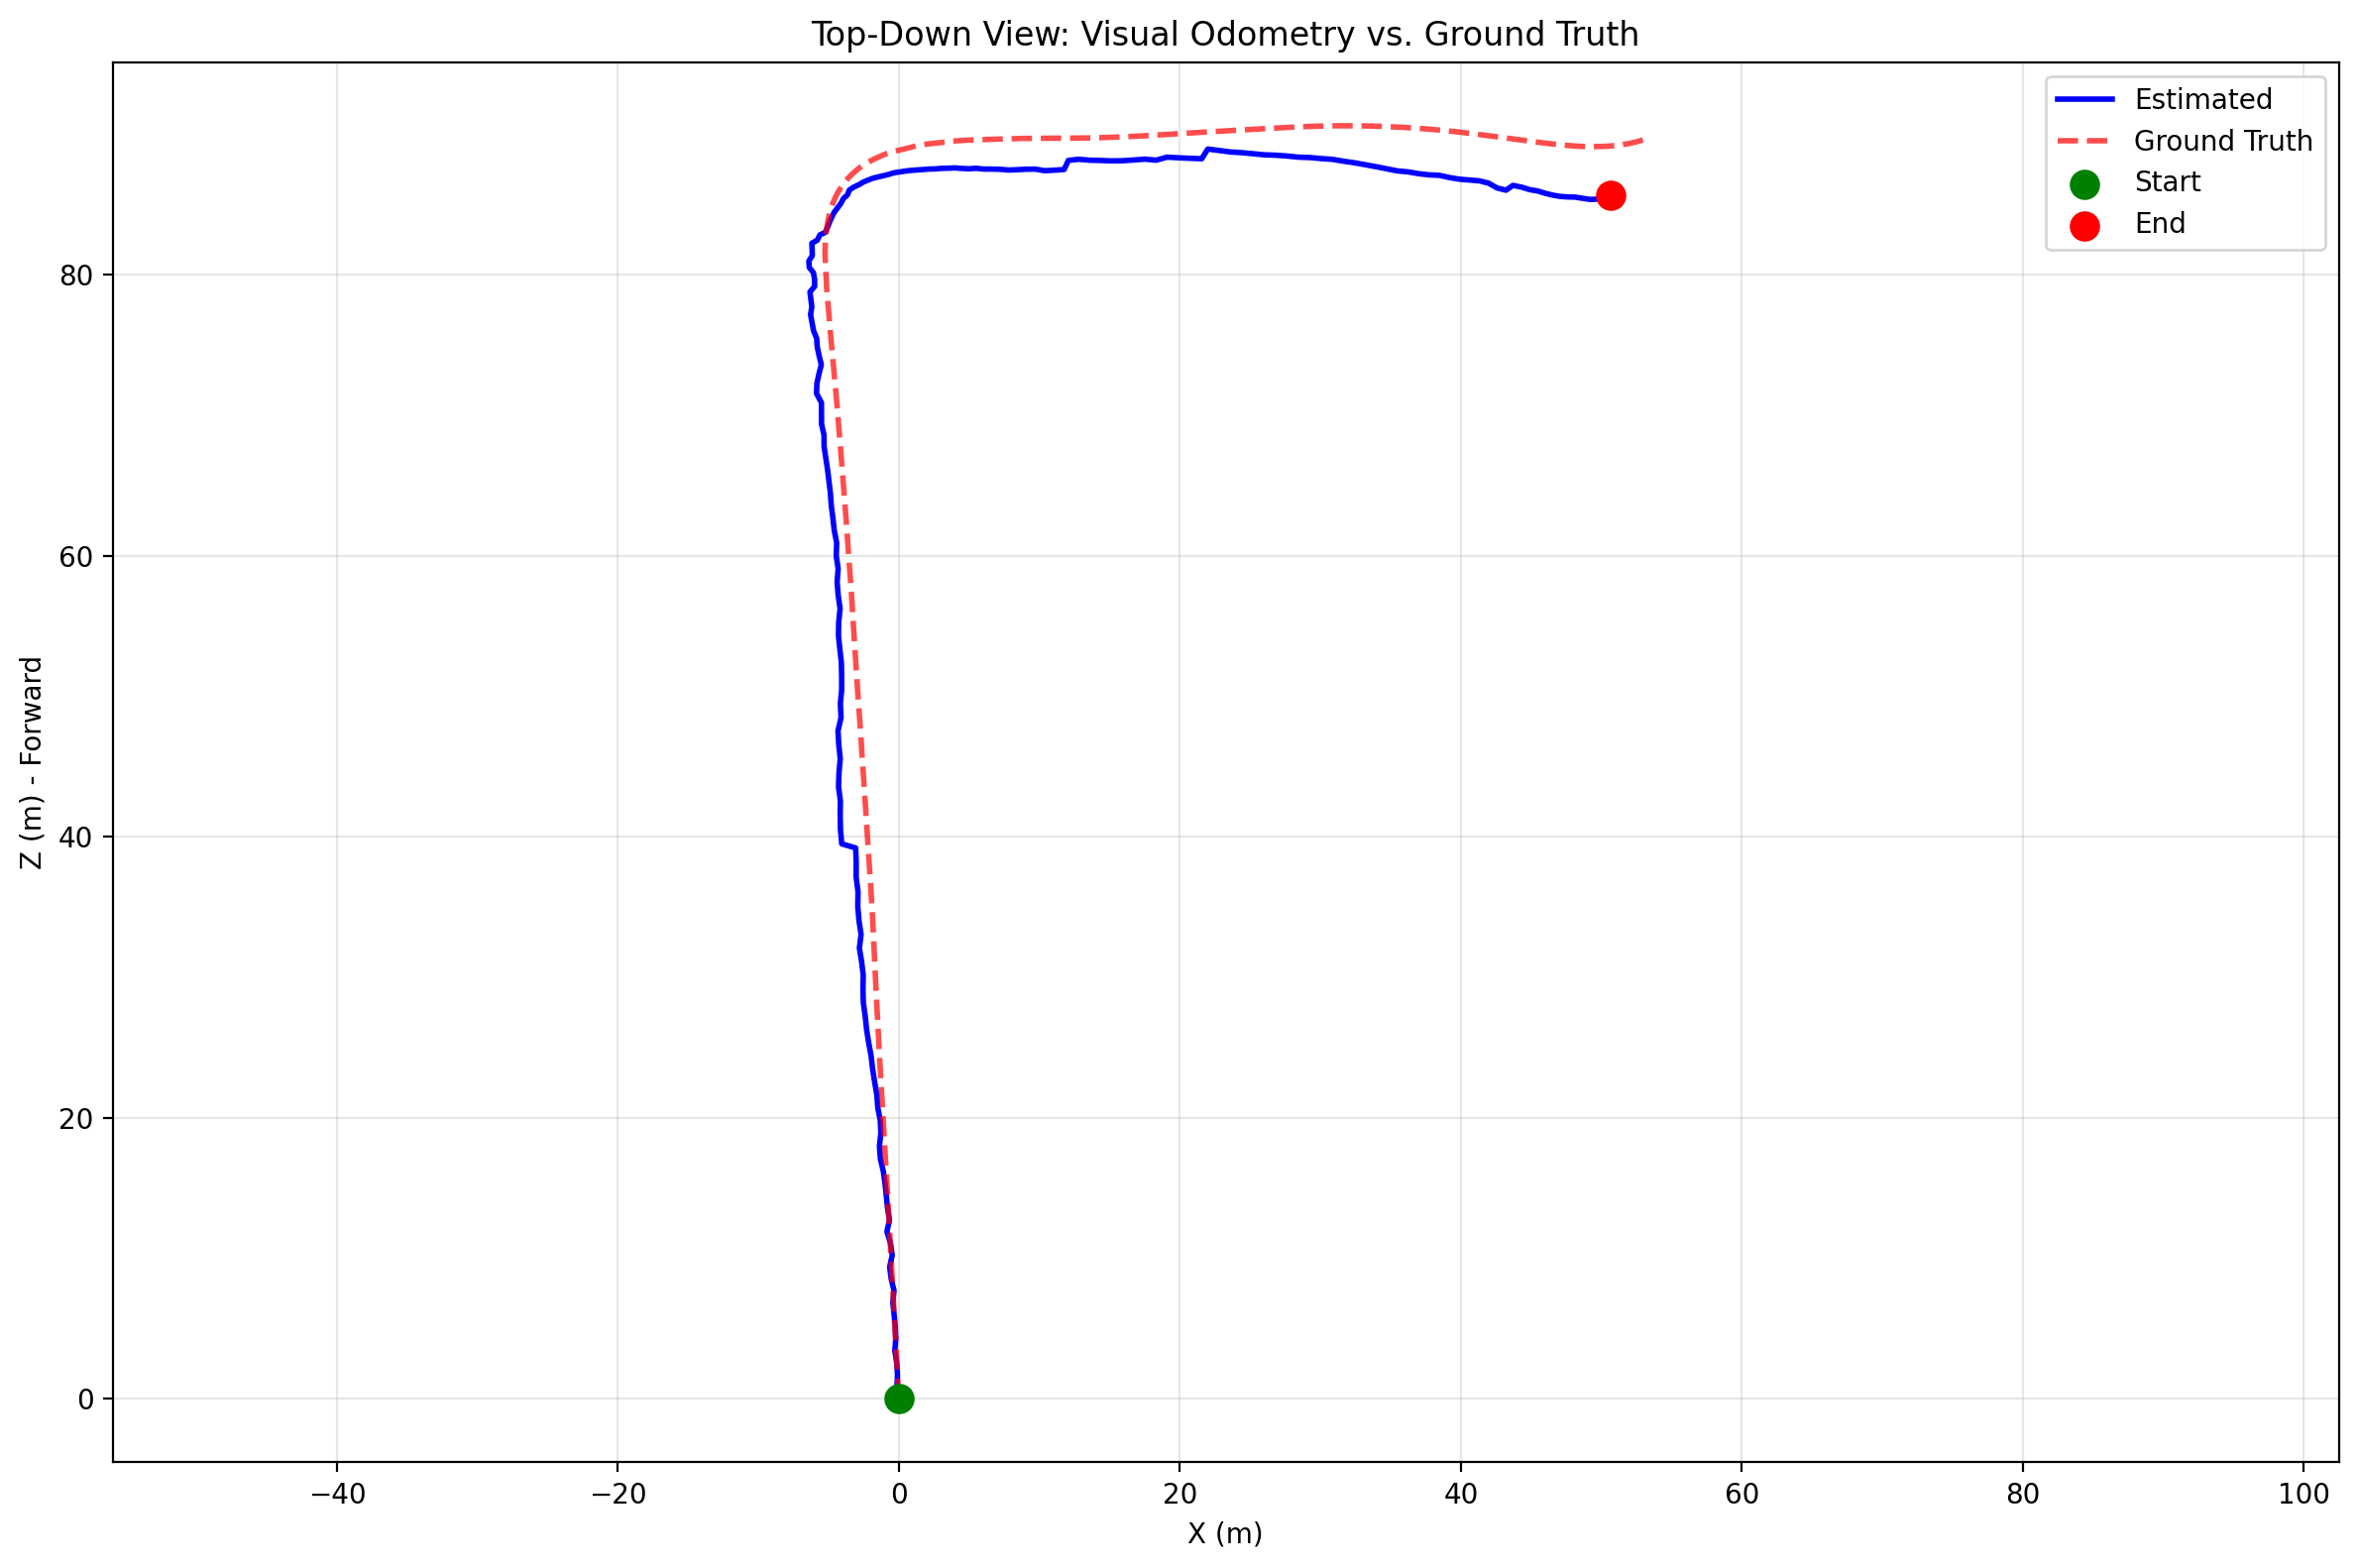


--- Trajectory Error Analysis ---
Root Mean Square (RMS) Position Error: 3.5189 meters
Mean Absolute Position Error:         3.0655 meters
Mean Relative Position Error:         0.0908 meters per frame
Mean Relative Rotation Error:         0.2681 degrees per frame


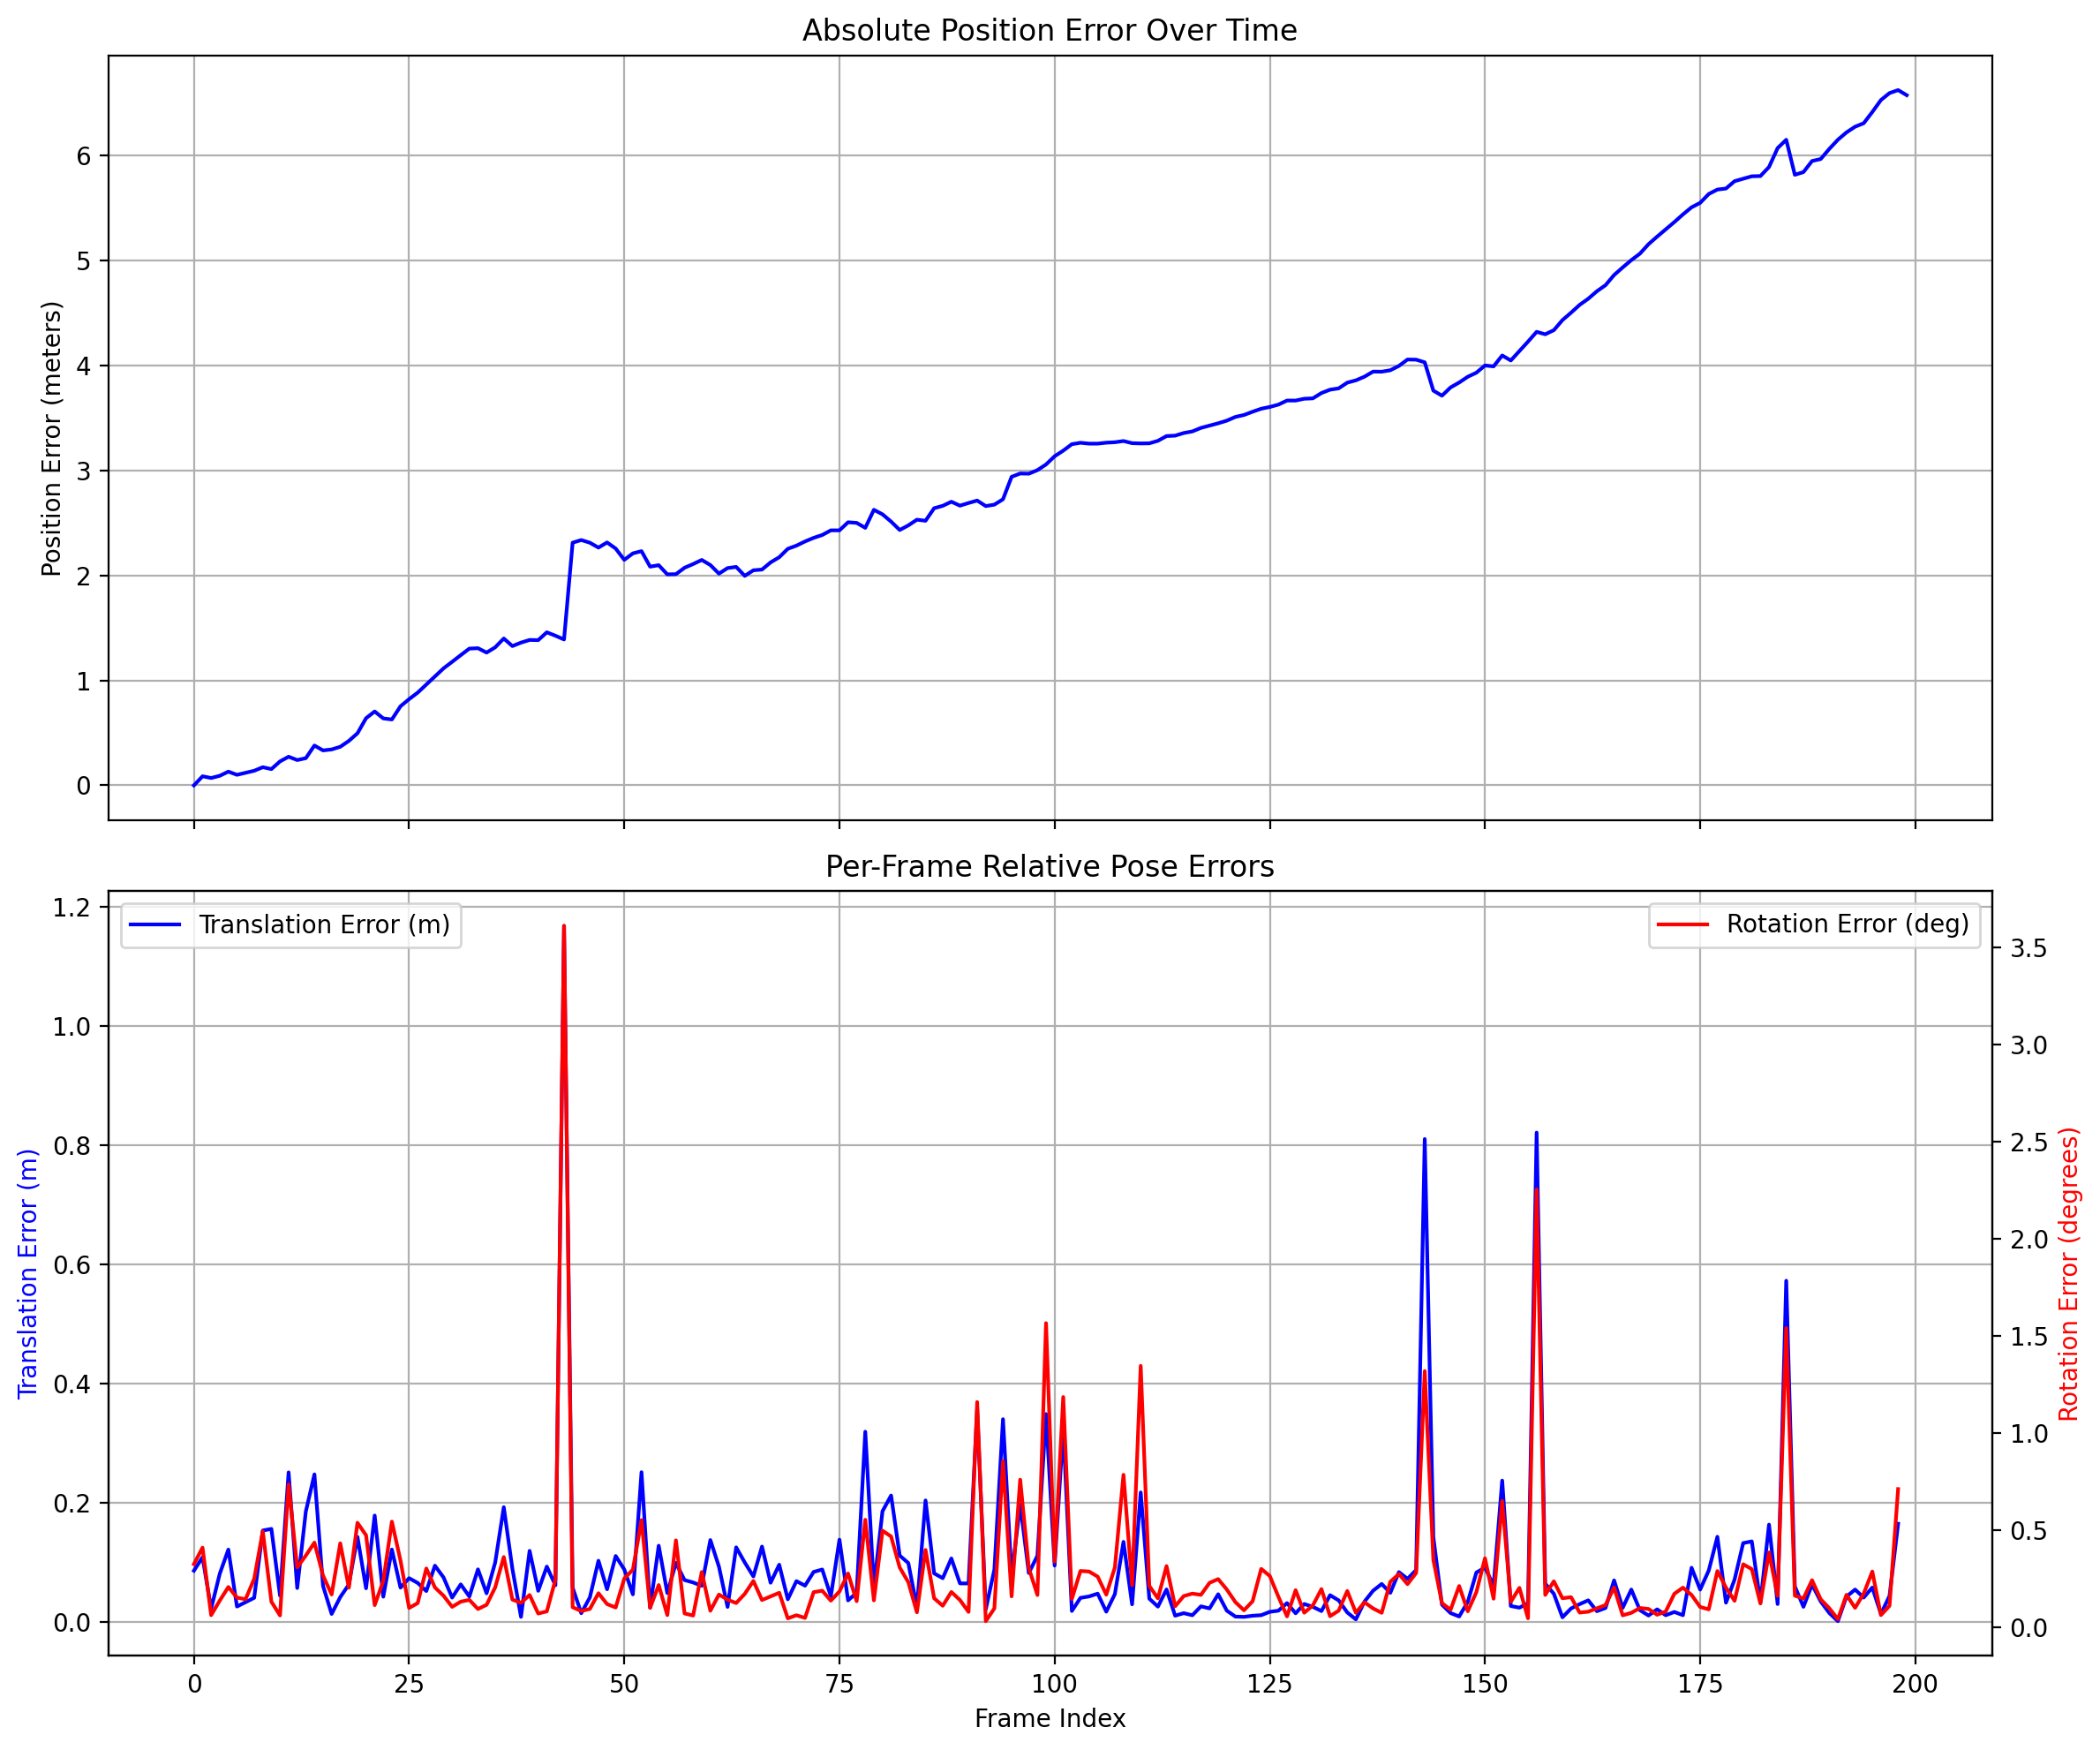

In [5]:
# --- Create a Top-Down View ---
# The top-down view is the clearest way to see the trajectory results.
# It shows the path on the ground (X-Z plane) and ignores the noisy altitude (Y).
plot_top_down_trajectory(
    estimated_poses,
    ground_truth_poses[:len(estimated_poses)],
    title="Top-Down View: Visual Odometry vs. Ground Truth"
)

# --- Calculate and Print Errors ---
errors = compute_trajectory_error(estimated_poses, ground_truth_poses[:len(estimated_poses)])

print("\n--- Trajectory Error Analysis ---")
print(f"Root Mean Square (RMS) Position Error: {errors['rms_position_error']:.4f} meters")
print(f"Mean Absolute Position Error:         {errors['mean_position_error']:.4f} meters")
print(f"Mean Relative Position Error:         {errors['mean_rpe_trans']:.4f} meters per frame")
print(f"Mean Relative Rotation Error:         {np.degrees(errors['mean_rpe_rot']):.4f} degrees per frame")

# --- Plot Error Over Time ---
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 10), sharex=True)

# Absolute Position Error
ax1.plot(errors['absolute_position_error'], color='b')
ax1.set_title('Absolute Position Error Over Time')
ax1.set_ylabel('Position Error (meters)')
ax1.grid(True)

# Relative Pose Errors
ax2.plot(errors['relative_position_error'], color='b', label='Translation Error (m)')
ax2_twin = ax2.twinx()
ax2_twin.plot(np.degrees(errors['relative_rotation_error']), color='r', label='Rotation Error (deg)')
ax2.set_title('Per-Frame Relative Pose Errors')
ax2.set_xlabel('Frame Index')
ax2.set_ylabel('Translation Error (m)', color='b')
ax2_twin.set_ylabel('Rotation Error (degrees)', color='r')
ax2.legend(loc='upper left')
ax2_twin.legend(loc='upper right')
ax2.grid(True)

plt.tight_layout()
plt.show()

### A Deeper Look at the 3D Trajectory: Why Did We Miss the Hill?

Finally, let's analyze the full 3D trajectory. While the top-down view is great for seeing the path, the 3D view reveals a fascinating and important limitation of our system.

As you can see in the plot below, the ground truth data (red dashed line) clearly shows the car driving up a gradual hill, climbing about 5 meters in altitude. However, our estimated trajectory (blue line) stays almost completely flat. **Our visual odometry system completely missed the climb.**

**Why does this happen?**

This is a classic example of how error accumulates in dimensions with weak geometric observability. The reason is that for a forward-facing camera, **the visual signal for a gentle climb is extremely weak and ambiguous.**

1.  **Strong vs. Weak Signals**: When the car moves *forward*, the entire visual scene expands, and objects stream past the sides. This is a very strong, clear signal that is easy to measure.
2.  **Ambiguous Uphill Signal**: When the car drives up a gentle slope, the only visual cue is that the entire scene—the horizon and all features—slowly and uniformly drifts *downwards* in the camera's view. This downward shift is tiny (perhaps only a fraction of a pixel per frame) and looks almost identical to a slight downward pitch of the car (e.g., from suspension bounce).
3.  **The Result**: The algorithm can't reliably distinguish the weak "climbing" signal from measurement noise or minor camera rotations. Faced with this ambiguity, it defaults to the most likely assumption: no vertical motion. The small errors in the vertical estimate then accumulate, leading to the noisy, flat trajectory you see.

This 3D plot is a perfect illustration of a core challenge in visual odometry: the system is only as good as the visual information it receives. It is very confident about the forward (Z) and sideways (X) motion but has very low confidence in its estimate of the vertical (Y) motion. More advanced systems solve this by fusing the camera data with an **IMU (Inertial Measurement Unit)**, which can directly measure the vehicle's tilt and provide the missing signal.

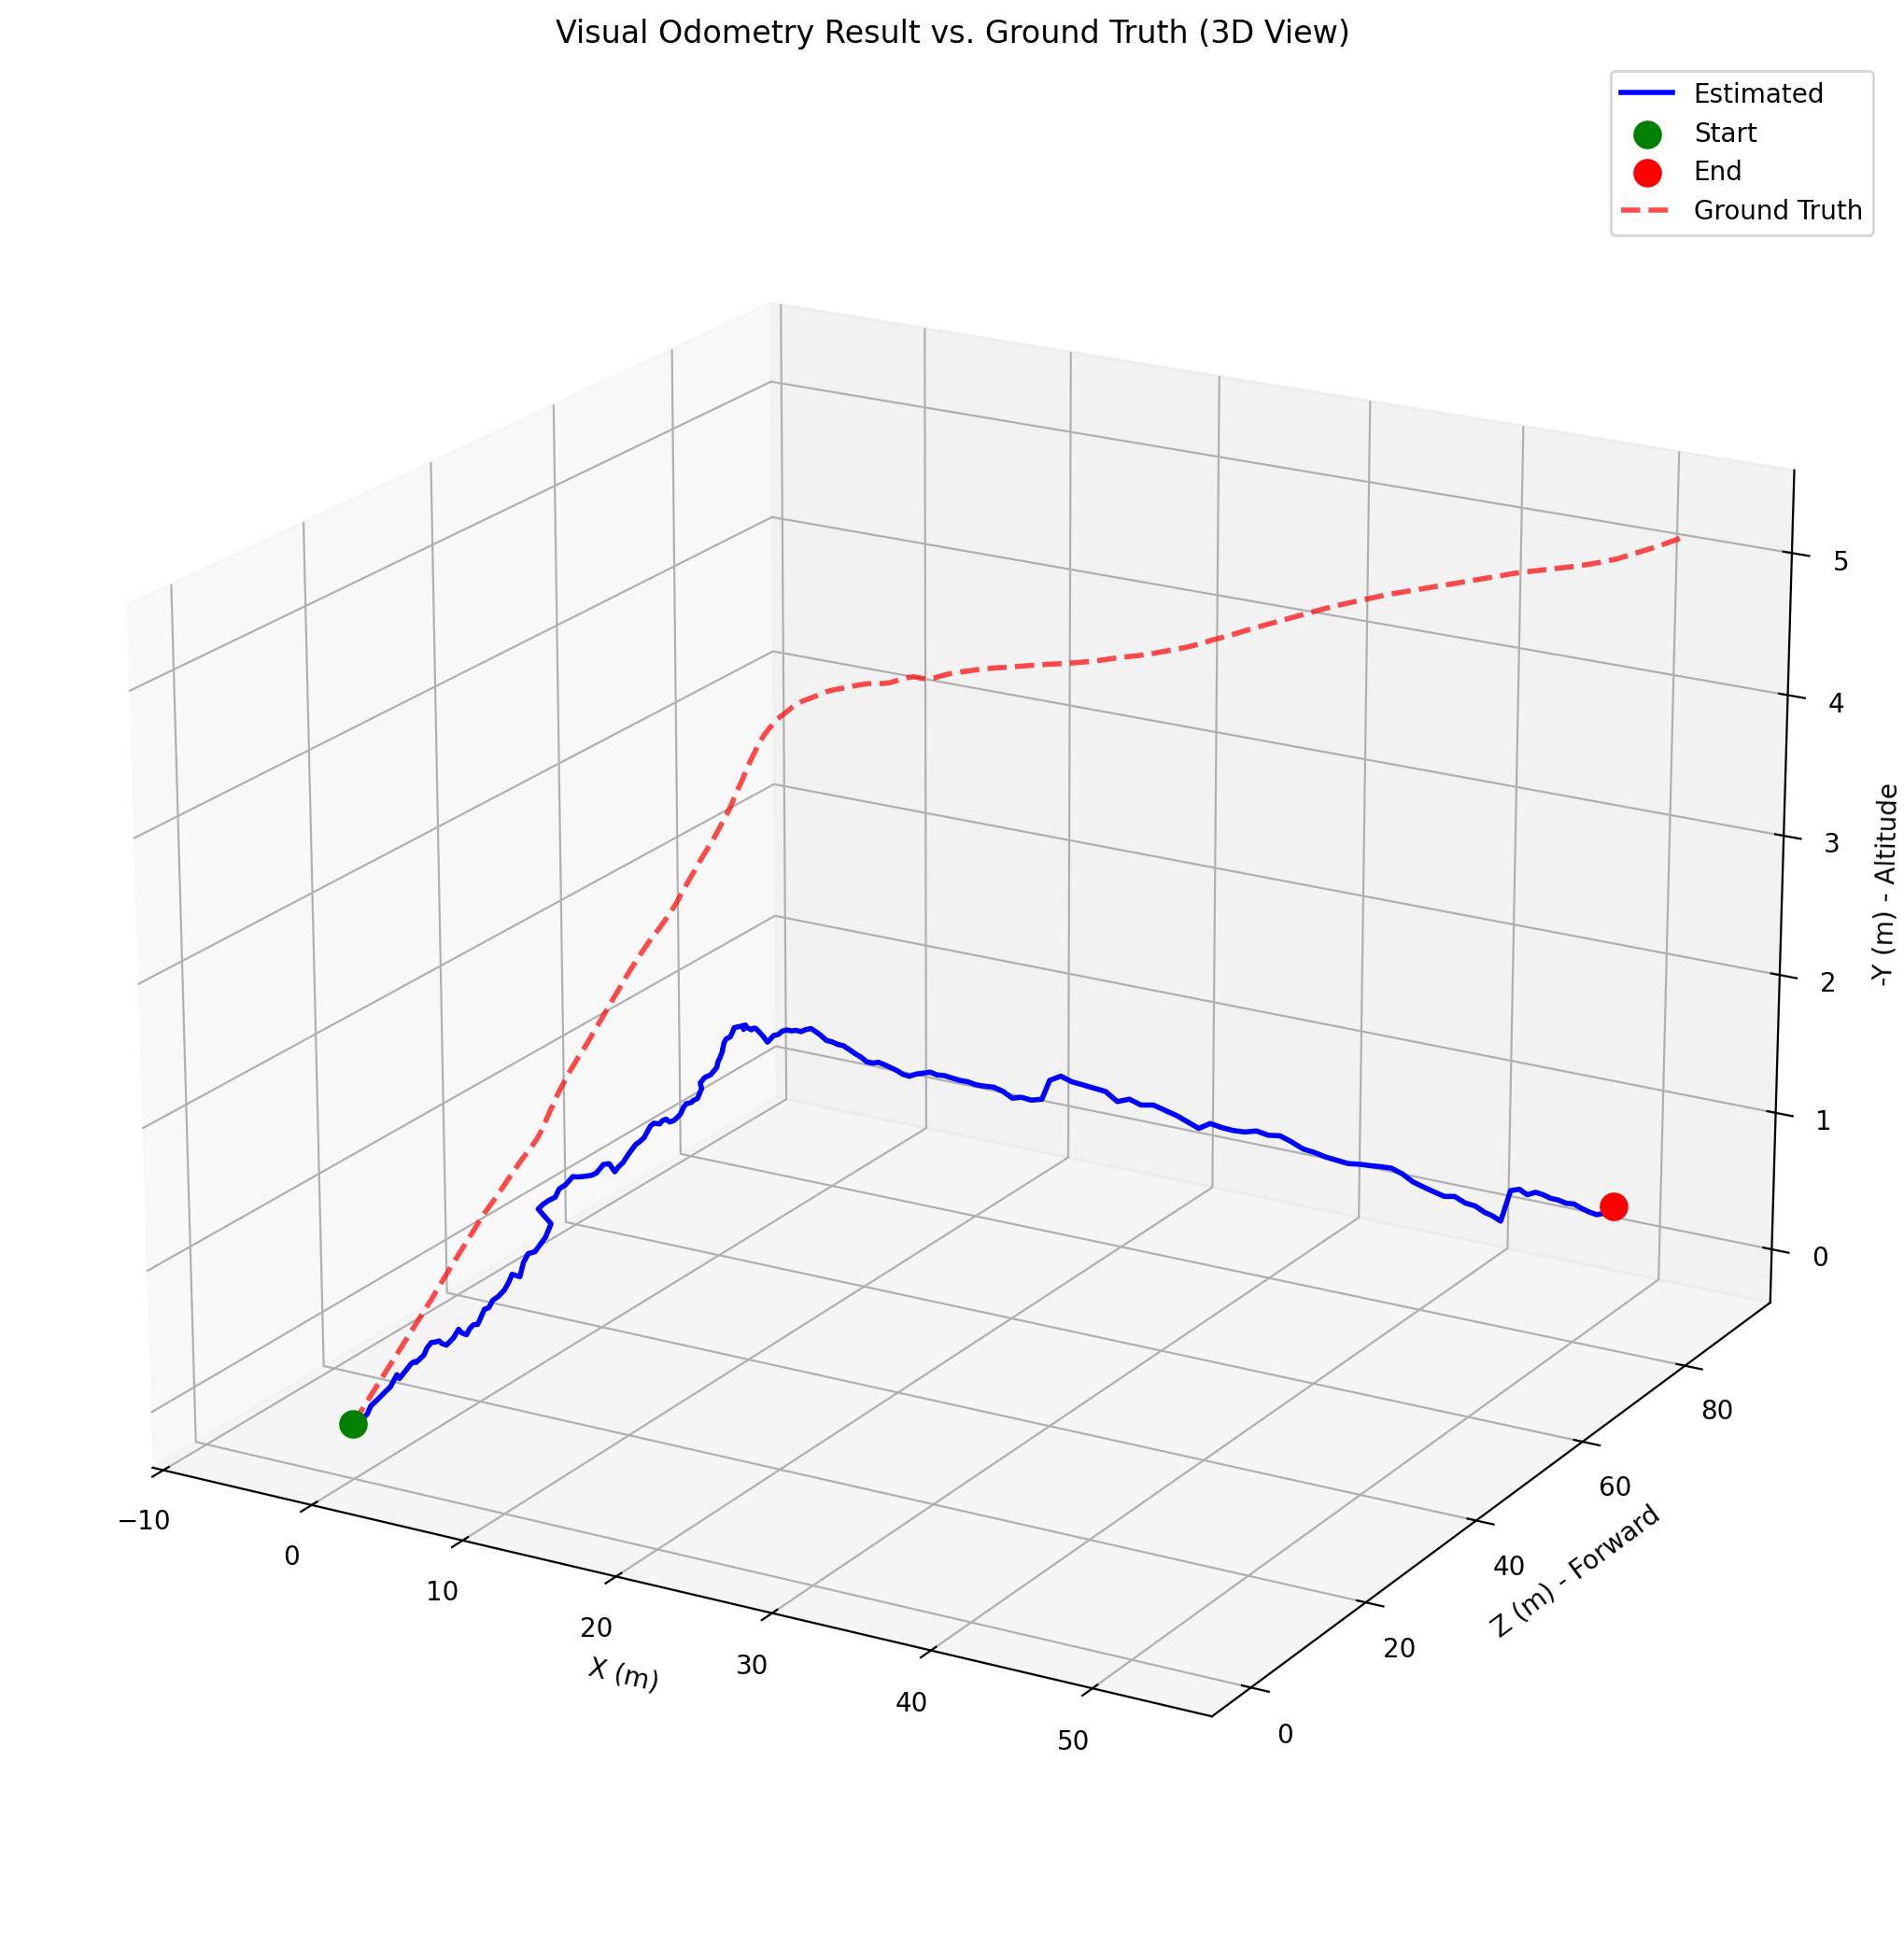

In [6]:
# Show the 3D trajectory using our utility function
plot_trajectory(
    estimated_poses,
    ground_truth_poses[:len(estimated_poses)],
    title="Visual Odometry Result vs. Ground Truth (3D View)"
)


## Conclusion

Congratulations! You've successfully implemented a complete visual odometry system from scratch. Here's what we accomplished:

1. **Feature Detection & Matching**: We used ORB features to find and track distinctive points between consecutive images.
2. **Pose Estimation**: We estimated camera motion using the Essential Matrix and RANSAC for robust outlier rejection.
3. **Trajectory Reconstruction**: We chained individual motions together to build the complete camera path.
4. **Error Analysis**: We quantified our system's performance against ground truth data.

### Key Observations

- The estimated trajectory follows the general shape of the ground truth quite well
- There is some drift accumulation over time, which is normal for visual odometry
- The scale ambiguity was resolved using ground truth (in Chapter 2, we'll solve this with stereo cameras)
- Feature matching quality directly affects pose estimation accuracy

### Next Steps

In **Chapter 2: Stereo Visual Odometry**, we'll address the scale ambiguity problem by using two cameras to perceive depth directly, eliminating the need for ground truth scale information.

The foundation you've built here with feature matching and pose estimation will be essential for more advanced techniques!